## Problem Overview


In **Sponsor Forecaster**, I will use several supervised learning algorithms to predict whether someone makes more than \$50,000 a year. I’ll start by running a few different models on data from the 1994 U.S. Census. After seeing which model performs best, I’ll focus on improving it to make more accurate predictions.

While one obvious use case is helping nonprofits estimate a person’s income to decide whether and how much to solicit in contributions, Sponsor Forecaster can also be used for:

* **Targeted Marketing:** Companies can infer income brackets to personalize promotions or product recommendations.
* **Credit Risk Assessment:** Lenders could screen loan or credit card applicants more efficiently by predicting income levels.
* **Housing & Rental Services:** Real estate platforms might gauge affordability when matching users with listings or rental offers.
* **Public Policy & Demographic Research:** Governments and think tanks can analyze income distributions across regions to inform social programs.
* **Job & Salary Benchmarking:** Recruitment firms might validate self-reported salaries or suggest appropriate salary ranges based on similar profiles.

Each scenario relies on the same idea: using publicly available features (age, education, occupation, etc.) to infer an individual’s income range. By adjusting input features or income thresholds (for example, \$75K instead of \$50K), Sponsor Forecaster can be adapted to various sectors with minimal tuning.

The data comes from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). It was contributed by Ron Kohavi and Barry Becker in their paper “Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid” (available [here](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf)). For our work, we’ll use a slightly cleaned version of that dataset: any rows with missing or malformed entries have been removed, and the `fnlwgt` feature is dropped.






----
## Exploring the Data
The last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. Compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

In [2]:
# Total number of records
n_records = len(data)

# Number of records where individual's income is more than $50,000
n_greater_50k = len(data[data.income=='>50K'])

# Number of records where individual's income is at most $50,000
n_at_most_50k = len(data[data.income=='<=50K'])

# Percentage of individuals whose income is more than $50,000
greater_percent = round(n_greater_50k/n_records * 100, 2)

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

A histogram of these two features is plotted to note the range of the values present and how they are distributed.

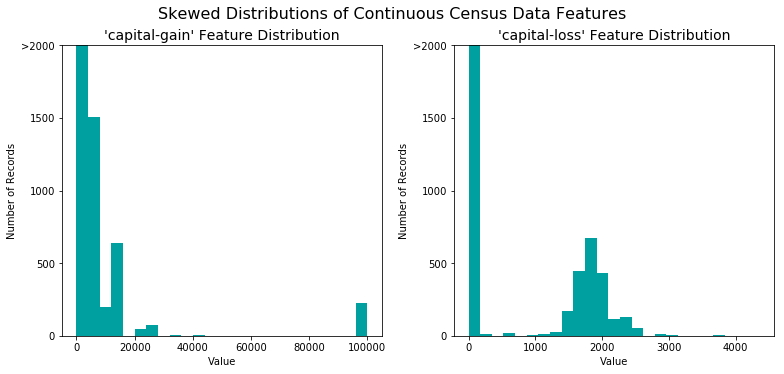

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

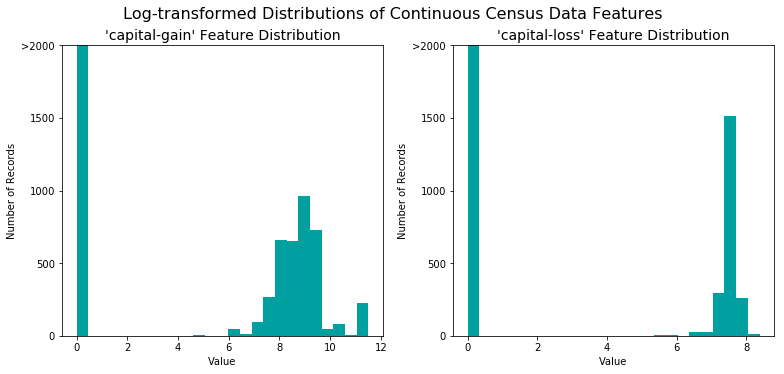

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Let's normalize each numerical feature by using [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.


Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively.
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [6]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
income = income_raw.apply(lambda x: 1 if x=='>50K' else 0)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
# print(encoded)

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [7]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners, and the fourth algorithm is known as a *naive predictor*.


###  Model Metrics & Naive Prediction

Since people earning over \$50,000 are more likely to donate, my goal is to predict them accurately. While accuracy seems like a good metric, it’s not enough—because if I simply predicted “everyone earns less,” I'd be mostly right, but I’d miss potential donors. That’s called a **naive predictor**, and it’s a bad strategy.

To do better, I focus more on **precision** (correctly identifying high earners) rather than **recall** (catching all of them). That’s why I use the **F-beta score**, which balances precision and recall. In this case, I choose **F<sub>0.5</sub>**, which puts more weight on precision.

---

###  Quick Metric Recap

* **Accuracy** = Correct predictions / Total predictions
* **Precision** = Correctly predicted positives / All predicted positives
* **Recall** = Correctly predicted positives / All actual positives

In imbalanced datasets (like this one), accuracy can be misleading. So I rely more on **precision**, **recall**, and their combination: the **F-score** (harmonic mean of precision and recall). A higher F-score means a better-performing model.

---


### Naive Predictor Performance

If I used a model that **always predicts everyone earns over \$50K**, here's what happens:

* **Accuracy** = % of actual high earners in the data (since it only predicts "yes")
* **Recall** = 1 (because it catches all actual positives)
* **Precision** = low (many predictions are wrong because it labels everyone as "yes")

This “naive” model helps set a **basic benchmark**. Even though it's unrealistic, it shows how poor performance can look without smart decision-making. My goal is to build a model that clearly outperforms this baseline.

---


In [8]:
TP = np.sum(income) # Counting the ones as this is the naive case.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# Calculate accuracy, precision and recall
accuracy = TP/income.count()
recall = TP/(TP + FN)
precision = TP/(TP + FP)

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
beta = 0.5
fscore = (1 + beta**2) * (precision * recall)/(beta**2*precision + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**Examples:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Choosing Models

I’ll test three supervised learning models on the census data. For each one, I’ll explain:

* A real-world use case
* Where it performs well
* Where it struggles
* Why it’s a good fit for this problem

This helps me compare their strengths and pick the best model for predicting income.



---

### Models I'm Testing

#### 1. Gaussian Naive Bayes (GaussianNB)

* **Used in:** Spam filtering, document classification
* **Good at:** Handling many features, fast and simple on small datasets
* **Struggles with:** High bias, no tuning options, not ideal for large/complex data
* **Why I picked it:** My data has lots of features — Naive Bayes handles that well and gives a quick baseline.

---

#### 2. Decision Tree

* **Used in:** Customer service tools (guiding support decisions)
* **Good at:** Handling both numerical and categorical data, easy to understand
* **Struggles with:** Overfitting, especially if the data is unbalanced
* **Why I picked it:** My dataset has mixed types and I want model transparency.

---

#### 3. AdaBoost (Ensemble Method)

* **Used in:** Face and object detection
* **Good at:** Boosting weak models to high accuracy, less parameter tuning needed
* **Struggles with:** Sensitive to noise and outliers
* **Why I picked it:** My data is clean, and I want a strong, accurate model.

---


### Implementation - Creating a Training and Predicting Pipeline
To create a training and predicting pipeline, let's implement the following:
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.

In [1]:
from sklearn.metrics import fbeta_score,accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], 
    # training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    # then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
To perform initial model evaluation, we will:
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

GaussianNB trained on 361 samples.
GaussianNB trained on 3617 samples.
GaussianNB trained on 36177 samples.
DecisionTreeClassifier trained on 361 samples.
DecisionTreeClassifier trained on 3617 samples.
DecisionTreeClassifier trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.


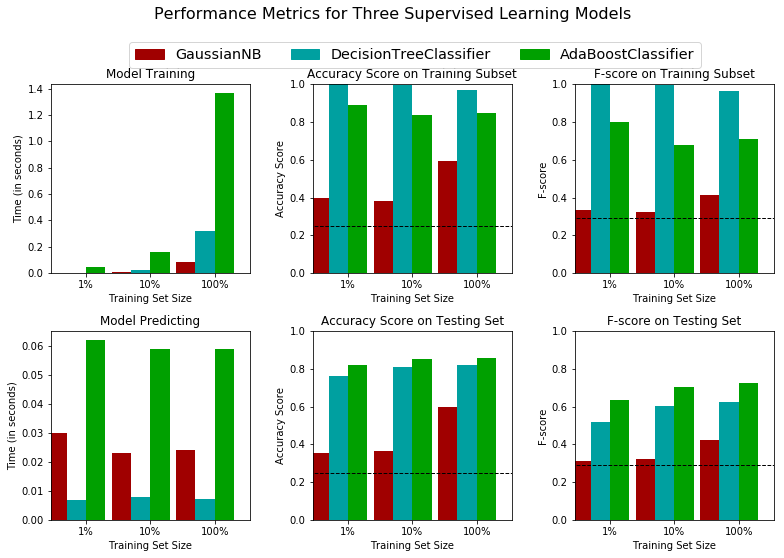

In [10]:
# Import the three supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# Initialize the three models
clf_A = GaussianNB()
clf_B = DecisionTreeClassifier(random_state=1)
clf_C = AdaBoostClassifier(random_state=1)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
# samples_100 is the entire training set i.e. len(y_train)
# samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = int(len(y_train) * 0.1)
samples_1 = int(len(y_train) * 0.01)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
Choose from the three supervised learning models the *best* model to use on the student data. Then, perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model

In [51]:
print('--------------------------------------------------------')
for i in results.items():
    print('\t\t'+i[0])
    display(pd.DataFrame(i[1]).rename(columns={0:'1% of Training Set', 1:'10% of Training Set', 2:'Entire Training Set'}))
    print('--------------------------------------------------------')

--------------------------------------------------------
		GaussianNB


,1% of Training Set,10% of Training Set,Entire Training Set
acc_test,0.351797,0.366059,0.597678
acc_train,0.400000,0.383333,0.593333
f_test,0.310134,0.320258,0.420899
f_train,0.333333,0.325092,0.412500
pred_time,0.030052,0.023061,0.024064
train_time,0.002006,0.008995,0.085205


--------------------------------------------------------
		DecisionTreeClassifier


,1% of Training Set,10% of Training Set,Entire Training Set
acc_test,0.761968,0.807186,0.817910
acc_train,1.000000,0.996667,0.970000
f_test,0.519912,0.604957,0.626563
f_train,1.000000,0.997191,0.963855
pred_time,0.006998,0.008022,0.007029
train_time,0.001003,0.022059,0.318849


--------------------------------------------------------
		AdaBoostClassifier


,1% of Training Set,10% of Training Set,Entire Training Set
acc_test,0.820674,0.849862,0.857601
acc_train,0.893333,0.840000,0.850000
f_test,0.632757,0.701882,0.724551
f_train,0.801282,0.680147,0.711538
pred_time,0.062134,0.059158,0.059178
train_time,0.050132,0.157438,1.363603


--------------------------------------------------------


**Answer:**

AdaBoost is the clear winner for a few key reasons:

* It consistently gets the highest accuracy and F-score on the test set, whether I train on 1%, 10%, or 100% of the data.
* Decision Trees overfit (near-perfect scores on training but poor generalization), and GaussianNB lags behind AdaBoost in both metrics.
* Though AdaBoost takes a bit longer to train, its prediction time is still fast—and that small extra cost is worth it for the gain in accuracy.
* Since AdaBoost combines many weak learners into a strong one, it handles our clean, well-structured data very effectively.
-----

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values.

In [11]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer

# Initialize the classifier
clf = AdaBoostClassifier(random_state=1)

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {
    'n_estimators': [50, 100, 125, 150],
    'learning_rate': [0.1, 0.5, 1.0, 1.5]
}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
Final accuracy score on the testing data: 0.8645
Final F-score on the testing data: 0.7375


### Final Model Evaluation

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |        0.2478       |        0.8576     |   0.8645        |
| F-score        |        0.2917       |        0.7246     |   0.7375        |




My optimized model scores 0.8645 accuracy and 0.7375 F-score on the test data -- just a bit higher than the unoptimized version but substantially better than the naive baseline.
